<h1><center>Time Series Forecasting</center></h1>

<h2><center>Melody Lamphear</center></h2>

<h3><center>July 2018</center></h3>



# **Time Series Forecasting**

## Objective: Analyze and forecast unit sales for a specific category at an online retailer using Machine Learning.

Process:

1) Plot total sales series and examine the main features of the graph, to determine whether there is
    - a trend
    - a seasonal component
    - any residual fluctuations
    
2) Remove the trend and seasonal components to get a stationary residual series and forecast unit sales using the ARIMA model

3) Forecast sales for an item with Scikit Learn - Random Forest Regressor and incorporate extrapolated seasonality

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
#Import file containing weekly sales by item for 2 full consecutive years (2016 and 2017)
csv = "cleandata.csv"
fulldata = pd.read_csv(csv)
# fulldata.head()

In [3]:
#Understand # of rows in dataset
fulldata["Units"].size

53737

In [4]:
#Check for data types to see if any need to be transformed
fulldata.dtypes

Brand Name      object
Item ID          int64
size             int64
Fiscal Year      int64
WM Week #        int64
Date            object
Type            object
Units            int64
AUR TY         float64
dtype: object

In [5]:
#Transform report date to datetime and units to numeric values
newdata = pd.read_csv('cleandata.csv', parse_dates=['Date'])
# newdata["u"] = newdata["u"].apply(pd.to_numeric, errors='coerce')
# newdata.head()

In [6]:
#Double check data types have been transformed
newdata.dtypes

Brand Name             object
Item ID                 int64
size                    int64
Fiscal Year             int64
WM Week #               int64
Date           datetime64[ns]
Type                   object
Units                   int64
AUR TY                float64
dtype: object

In [7]:
#Plot daily sales over time 

# plt.figure(figsize=(10,8))
# plt.bar(newdata["Date"], newdata["Units"])
# plt.title("Units over time")
# plt.ylabel("Units")
# plt.xlabel("Time stamp")
# plt.ylim(0,13000)
# plt.grid(True)
# plt.show()

In [8]:
#Create Time Series (TS) to be utilized in the analysis

ts = pd.Series(newdata.groupby(["Date"])['Units'].sum())
# ts.head()

In [10]:
#Create function to test Stationarity of a Time Series and Analyze statistical data
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Forecasting with ARIMA
* Need to make time series stationary by removing seasonality and trend.
* Fit the ARIMA model with a stationary time series.

**ARIMA**

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average:

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

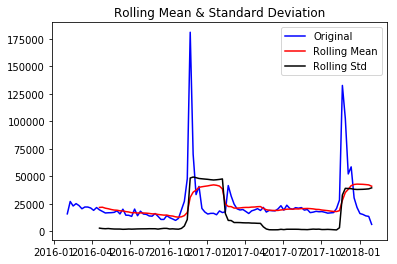

Results of Dickey-Fuller Test:
Test Statistic                  -5.545739
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [11]:
# First, let's test whether the time series is stationary or not
# Plotting rolling statistics: It is clear that there is a seasonality seen in Spring (Tax season) 
# and fourth quarter (holiday sales)
test_stationarity(ts)

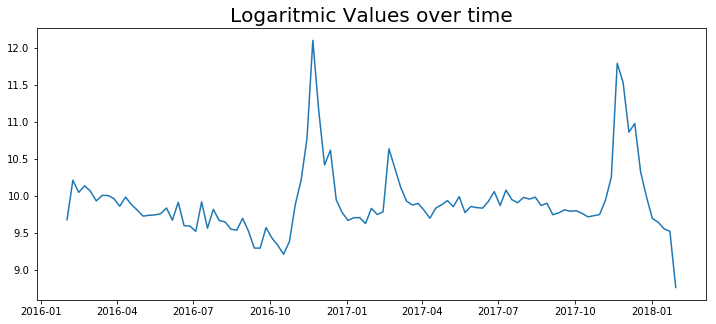

In [12]:
# First: use numpy's log function and see the trend in the time series
#As we can see there is remarakble seasonality spikes in the fourth quarters (weeks 40-50) that 
# will need to be smoothed
plt.figure(figsize=(12,5))
ts_log = np.log(ts)
plt.title("Logaritmic Values over time", size=20)
plt.plot(ts_log)
plt.show()

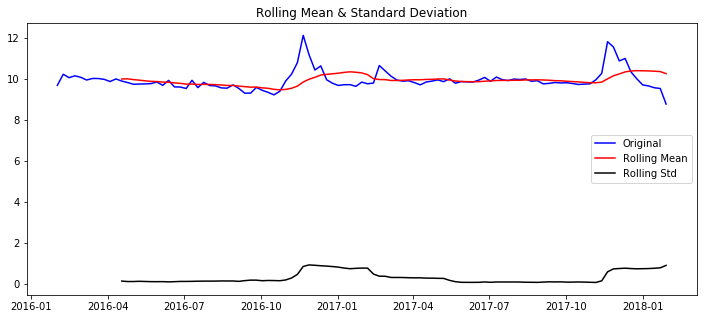

Results of Dickey-Fuller Test:
Test Statistic                  -4.482081
p-value                          0.000212
#Lags Used                       3.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [13]:
# Review stats for logaritmic time series.
plt.figure(figsize=(12,5))
test_stationarity(ts_log)

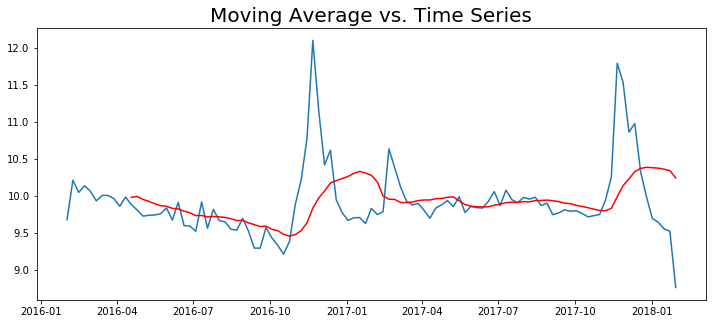

In [14]:
#Plot moving average:
plt.figure(figsize=(12,5))
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.title("Moving Average vs. Time Series", size=20)
plt.show()

* Notice the moving average is higher on the second year indicating an upwards trend

In [15]:
#Extrapolate trend, seasonality and residual
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

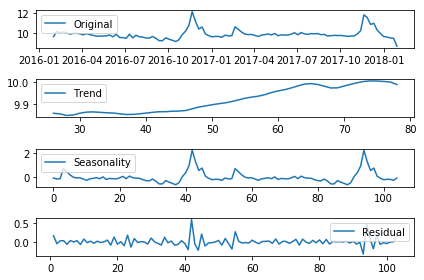

In [16]:
decomposition = sm.tsa.seasonal_decompose(ts_log.values, freq=52)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = sm.tsa.seasonal_decompose(ts_log.values, freq=2).resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

,Percent lift
0,NaN
1,1.160215
2,0.951355
3,1.025886
4,1.029208


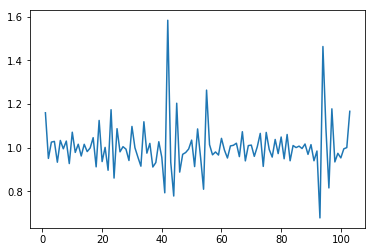

In [17]:
#Examine residual fluctuations (noise)
residual_fluctuations = pd.DataFrame(residual+1)
residual_fluctuations.columns=["Percent lift"]
plt.plot(residual_fluctuations)
residual_fluctuations.head()

,Percent lift
0,0.935995
1,0.848151
2,0.877344
3,1.723052
4,1.457503


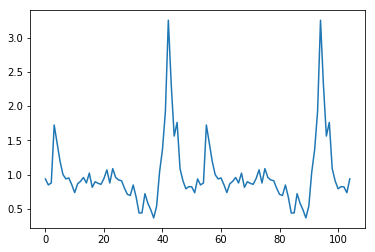

In [18]:
# Extrapolate seaonality builds to be used later
seasonal_lifts = pd.DataFrame(seasonal+1)
seasonal_lifts.columns=["Percent lift"]
plt.plot(seasonal_lifts)
seasonal_lifts.head()

Notes:
    - Seasonality shows a lift of 200+% during holiday spikes
    - Residuals show a lift of ~60% the week before the major seasonality spikes

In [19]:
#Create simpler function to test stationarity
def test_stationarity1(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

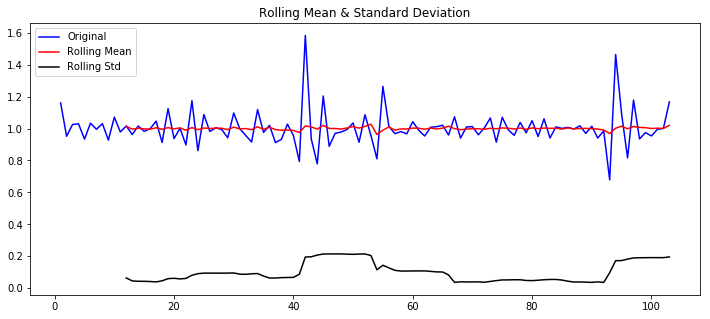

In [20]:
#Test stationarity over residual (noise) fluctuations
plt.figure(figsize=(12,5))
ts_log_decompose = residual_fluctuations
ts_log_decompose.dropna(inplace=True)
test_stationarity1(ts_log_decompose)

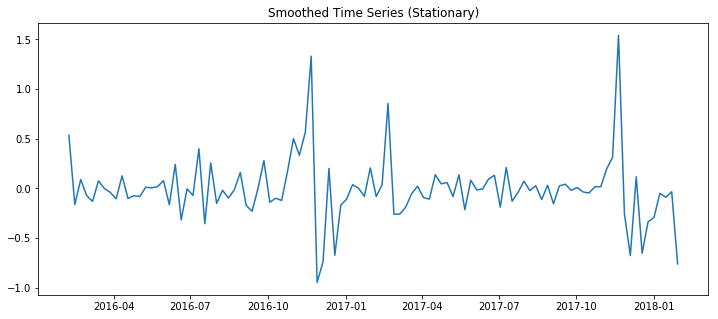

In [21]:
#Differencing in statistics is a transformation applied to time-series data in order to make it stationary 
# A stationary time series' properties do not depend on the time at which the series is observed.(https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average).
plt.figure(figsize=(12,5))
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.title("Smoothed Time Series (Stationary)")
plt.show()

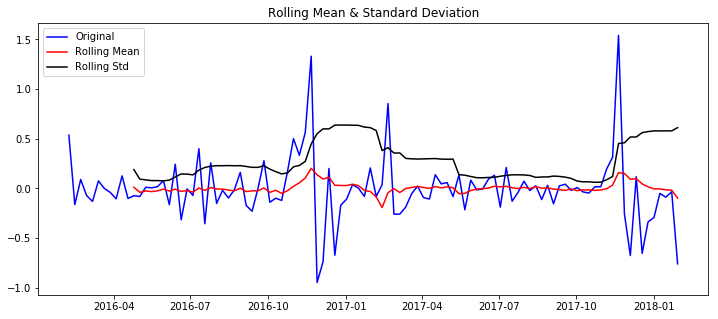

In [22]:
plt.figure(figsize=(12,5))
test_stationarity1(ts_log_diff)

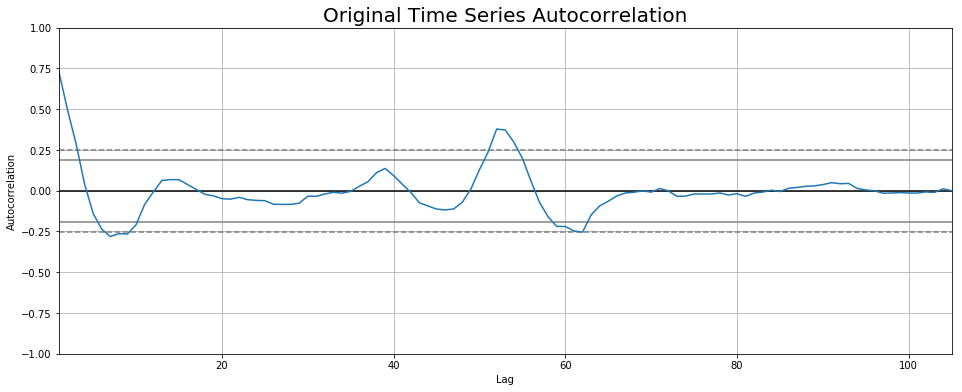

In [23]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(16,6))
autocorrelation_plot(ts_log)
plt.title("Original Time Series Autocorrelation", size=20)
plt.show()

We can see that there is a positive correlation with the first 7 or so lags and most significant for the first 5 lags.

A good starting point for the AR parameter of the model is 5.

In [24]:
# DEPLOY ARIMA MODEL
from statsmodels.tsa.arima_model import ARIMA

AR_model = ARIMA(ts_log, order=(5,1,0))  
results_AR = AR_model.fit(disp=-1)  
print(results_AR.summary())

# The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 
# The P>|z| column informs us of the significance of each feature weight. 
# We want a p-value lower or close to 0.05

                             ARIMA Model Results                              
Dep. Variable:                D.Units   No. Observations:                  104
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -28.713
Method:                       css-mle   S.D. of innovations              0.319
Date:                Mon, 09 Jul 2018   AIC                             71.427
Time:                        23:44:59   BIC                             89.938
Sample:                    02-08-2016   HQIC                            78.926
                         - 01-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0074      0.026     -0.289      0.773      -0.058       0.043
ar.L1.D.Units     0.0187      0.101      0.185      0.854      -0.180       0.217
ar.L2.D.Units    -0.0549      0.099     

In [25]:
# forecast = pd.Series(results_AR.forecast())
# print(forecast)

                0
count  104.000000
mean     0.000699
std      0.320394
min     -0.865404
25%     -0.144074
50%     -0.004709
75%      0.104292
max      1.548073


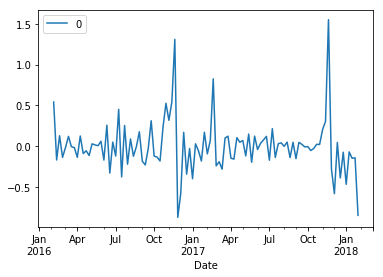

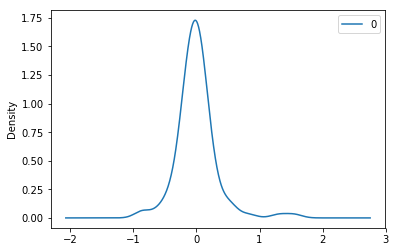

In [26]:
# Plot residual errors
residuals = pd.DataFrame(results_AR.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())
plt.show()

We still see some trend information not captured by the model.

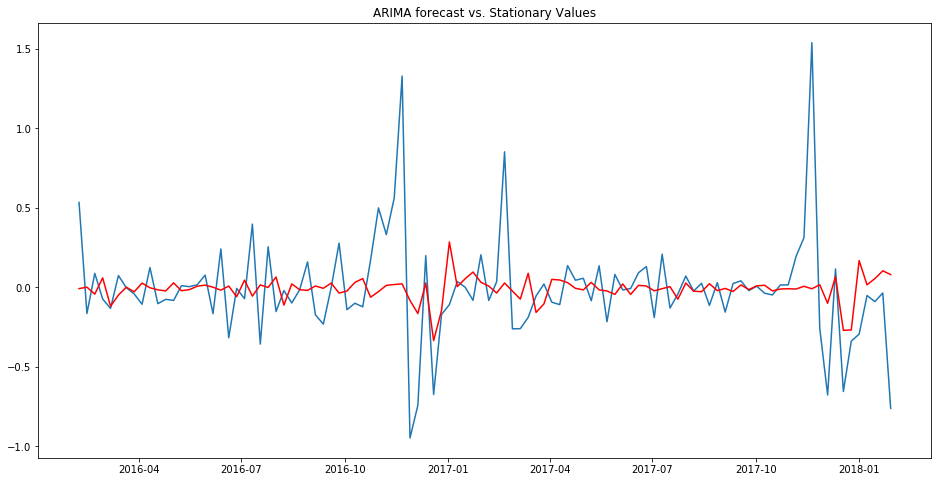

In [27]:
plt.figure(figsize=(16,8))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('ARIMA forecast vs. Stationary Values')
plt.show()

In [28]:
print(results_AR.fittedvalues)

Date
2016-02-08   -0.007424
2016-02-15    0.001870
2016-02-22   -0.041901
2016-02-29    0.060180
2016-03-07   -0.117991
2016-03-14   -0.048148
2016-03-21    0.001716
2016-03-28   -0.027343
2016-04-04    0.027326
2016-04-11   -0.002072
2016-04-18   -0.015030
2016-04-25   -0.021854
2016-05-02    0.028805
2016-05-09   -0.020700
2016-05-16   -0.013648
2016-05-23    0.007727
2016-05-30    0.014599
2016-06-06    0.001513
2016-06-13   -0.017075
2016-06-20    0.008802
2016-06-27   -0.058345
2016-07-04    0.045734
2016-07-11   -0.054474
2016-07-18    0.015858
2016-07-25    0.000024
2016-08-01    0.065450
2016-08-08   -0.110743
2016-08-15    0.022324
2016-08-22   -0.013932
2016-08-29   -0.018482
                ...   
2017-07-10   -0.007737
2017-07-17    0.005016
2017-07-24   -0.074004
2017-07-31    0.027928
2017-08-07   -0.023464
2017-08-14   -0.026828
2017-08-21    0.023612
2017-08-28   -0.019981
2017-09-04   -0.006289
2017-09-11   -0.025480
2017-09-18    0.016228
2017-09-25   -0.013768
2017-1

In [29]:
print(ts_log_diff)

Date
2016-02-01         NaN
2016-02-08    0.534894
2016-02-15   -0.163745
2016-02-22    0.088617
2016-02-29   -0.072708
2016-03-07   -0.131760
2016-03-14    0.074845
2016-03-21   -0.001446
2016-03-28   -0.040749
2016-04-04   -0.105826
2016-04-11    0.125369
2016-04-18   -0.101928
2016-04-25   -0.074683
2016-05-02   -0.081730
2016-05-09    0.011003
2016-05-16    0.004897
2016-05-23    0.016868
2016-05-30    0.077698
2016-06-06   -0.164973
2016-06-13    0.241888
2016-06-20   -0.316404
2016-06-27   -0.006006
2016-07-04   -0.070980
2016-07-11    0.398435
2016-07-18   -0.356273
2016-07-25    0.256047
2016-08-01   -0.151518
2016-08-08   -0.019674
2016-08-15   -0.097546
2016-08-22   -0.014446
                ...   
2017-07-10    0.209374
2017-07-17   -0.129647
2017-07-24   -0.040888
2017-07-31    0.071619
2017-08-07   -0.022579
2017-08-14    0.026101
2017-08-21   -0.113048
2017-08-28    0.030400
2017-09-04   -0.155290
2017-09-11    0.024861
2017-09-18    0.041429
2017-09-25   -0.020023
2017-1

In [30]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2016-02-08   -0.007424
2016-02-15    0.001870
2016-02-22   -0.041901
2016-02-29    0.060180
2016-03-07   -0.117991
dtype: float64

In [31]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2016-02-08   -0.007424
2016-02-15   -0.005554
2016-02-22   -0.047455
2016-02-29    0.012725
2016-03-07   -0.105267
dtype: float64

In [32]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2016-02-01    9.675269
2016-02-08    9.667845
2016-02-15    9.669714
2016-02-22    9.627814
2016-02-29    9.687993
dtype: float64

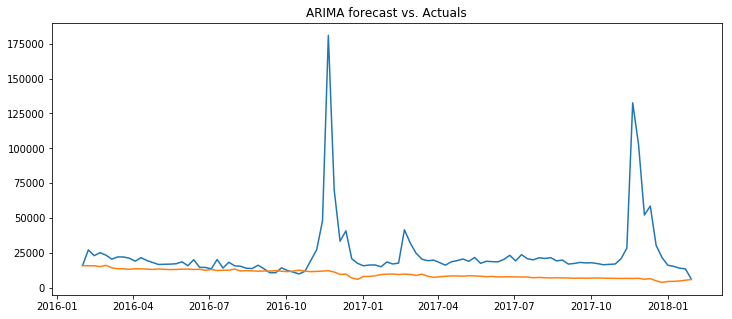

In [33]:
# After scaling back the data: Review forecast vs. Actuals:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(12,5))
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title("ARIMA forecast vs. Actuals")
plt.show()

# Forecasting sales for a specific item with Scikit Learn

Developed process to provide a unit forecast for an item based on a group of parameter:

1) Process to import daily level sales data for top selling items in the category (earlier we extrapolated weekly seasonality builds to help forecast the rest of the year)
    - Data excluded holiday spike weeks to help determine "normal" run rates for items. Weeks included in dataset: 1-39
2) Utilization of Scikit Learn Random Forest Regression to extrapolate weekly sales for a item with a specific size and for a specific group of weeks.

In [34]:
csvfile = "cleandata8.csv"
data = pd.read_csv(csvfile, parse_dates=["Day(Report Date)"])
# data.head()

In [35]:
data["ID"].size

18107

In [36]:
data.dtypes

sale                        object
Day(Report Date)    datetime64[ns]
ID                           int64
week                         int64
year                         int64
u                            int64
p                          float64
Lift_DOD                   float64
change in p                  int64
Lift_retail                float64
Lift_2DOD                  float64
Lift_2retail               float64
Size                         int64
Weekday                      int64
Top item                     int64
avg prev units              object
after units                float64
unit lift                   object
price lift                 float64
dtype: object

In [37]:
x = data[["Lift_retail","Size", "p", "week"]]
y = data["u"].values

In [38]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [39]:
##Select Scikit-Learn model

# try Random Forest Regressor --> works well R2 Score: 0.6759827416165034
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

#  try nearest - works well with an identical R2 Score: 0.6759827416165034
# from sklearn.neighbors import KNeighborsRegressor
# neigh = KNeighborsRegressor(n_neighbors=2)

# try SGD regressor
# model = linear_model.SGDRegressor() --> does not work well

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [40]:
predictions = model.predict(X_test)
comparison = pd.DataFrame({"Predicted": predictions, "Actual": y_test, "Error": predictions - y_test})[["Predicted", "Actual", "Error"]] 
comparison.head(40)

,Predicted,Actual,Error
0,60.416000,57,3.416000
1,29.314024,68,-38.685976
2,15.103521,20,-4.896479
3,6.887025,11,-4.112975
4,8.255788,2,6.255788
5,73.591054,84,-10.408946
6,3.398317,5,-1.601683
7,31.945083,28,3.945083
8,61.971070,104,-42.028930
9,107.796234,24,83.796234


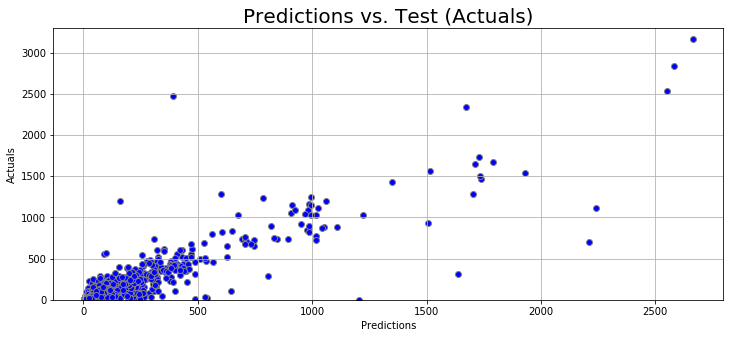

In [41]:
plt.figure(figsize=(12,5))
plt.scatter(predictions, y_test, facecolors='blue', edgecolor='grey')
plt.title("Predictions vs. Test (Actuals)", size=(20))
plt.ylabel("Actuals")
plt.xlabel("Predictions")
plt.ylim(0,3300)
# plt.xlim(0,3000)
plt.grid(True)
plt.show()

In [42]:
# Check quality of the model
score = model.score(X_test, y_test)
print(f"R2 Score: {score}")

R2 Score: 0.6759827416165034


In [40]:
# from numpy import sqrt
# from sklearn.metrics import mean_squared_error, mean_squared_log_error

# def rmsle(predictions, y_test):
#     return np.sqrt(mean_squared_error(predictions, y_test))

# Apply model to a real life question: 
How many units can I sell on an item of a specific size and price?

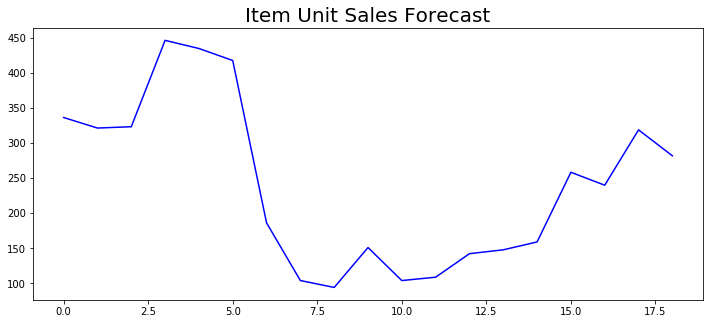

In [43]:
# Forecast units based on: x = data[["Lift_retail","Size", "p", "week number"]]
weekly_sales = []
week_nbr = []
parameter = []
for weeks in range (1,20):
    forecast = model.predict([[-0.05, 32, 109.99, weeks]])
    weekly_sales.append(forecast)
    nbr = weeks
    week_nbr.append(nbr)
    parameter.append(["-0.05, 32, 109.99"])
weekly_sales

weekly_sales_df = pd.DataFrame({"Units":weekly_sales, "Week":week_nbr, "Param":parameter})
plt.figure(figsize=(12,5))
plt.plot(weekly_sales_df["Units"], color='blue')
plt.title("Item Unit Sales Forecast", size=20)
plt.show()

In [44]:
weekly_sales_df

,Param,Units,Week
0,"[-0.05, 32, 109.99]",[336.43275],1
1,"[-0.05, 32, 109.99]",[321.40975],2
2,"[-0.05, 32, 109.99]",[323.309727453],3
3,"[-0.05, 32, 109.99]",[446.399505952],4
4,"[-0.05, 32, 109.99]",[434.79785873],5
5,"[-0.05, 32, 109.99]",[417.695333333],6
6,"[-0.05, 32, 109.99]",[186.320866667],7
7,"[-0.05, 32, 109.99]",[104.107766667],8
8,"[-0.05, 32, 109.99]",[94.2372694444],9
9,"[-0.05, 32, 109.99]",[151.115001948],10


Note: We will take 336 as the base forecast

## Final Step 
- Apply seasonality builds extrapolated during ARIMA exercise to Scikit Learn's new unit sale rate to create a  two year sales forecast

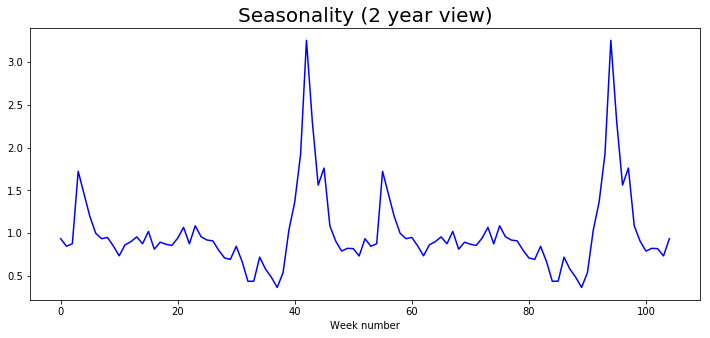

In [45]:
# Plot seasonality builds extrapolated from ARIMA's process above
seasonal_pct = pd.Series(seasonal+1)
plt.figure(figsize=(12,5))
plt.plot(seasonal_pct, color="blue")
plt.title("Seasonality (2 year view)", size=20)
plt.xlabel("Week number")
plt.show()
# seasonal_pct

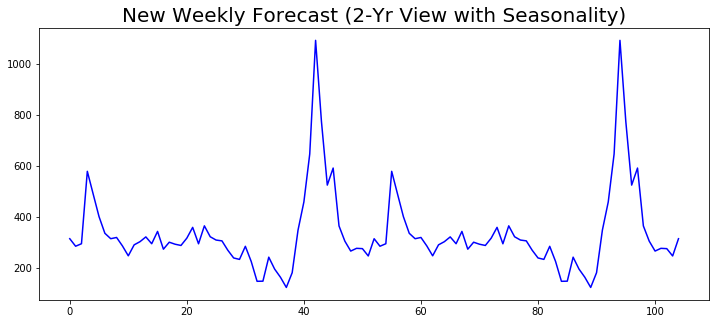

In [46]:
base = 336
weekly_fcst_seasonal = []
week_counter = 0
week = []
for x in seasonal_pct:
        unit_fcst = base * x
        weekly_fcst_seasonal.append(unit_fcst)
        week_counter+=1
        week.append(week_counter)
    
forecast_df_final = pd.DataFrame({"Week_nbr":week, "Unit_Fcst":weekly_fcst_seasonal})
plt.figure(figsize=(12,5))
plt.title("New Weekly Forecast (2-Yr View with Seasonality)", size=20)
plt.plot(weekly_fcst_seasonal, color="blue")
plt.show()

In [47]:
forecast_df_final

,Unit_Fcst,Week_nbr
0,314.494408,1
1,284.978665,2
2,294.787530,3
3,578.945377,4
4,489.721123,5
5,401.198698,6
6,335.735078,7
7,314.497056,8
8,319.358101,9
9,286.206896,10


# Questions?


![meme.jpg](meme.jpg)

References: 2002-Brockwell-Introduction Time Series and Forecasting